In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
#import xclim as xc
import os
from memory_profiler import profile
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
import matplotlib.gridspec as gridspec
import pandas as pd
from matplotlib import rcParams
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi

In [28]:

d2m = xr.open_dataset("/data/user/jkjellsson/era-20c/td2m/td2m_era20c_1900-2010.nc").isel(latitude = 0, longitude = 0)
t2m = xr.open_dataset("/data/user/jkjellsson/era-20c/t2m/t2m_era20c_1900-2010.nc").isel(latitude = 0, longitude = 0)
st = time.time()
swbgt = humidcalc.swbgt_func(t2m.t2m -273.15,d2m.d2m -273.15)
print(time.time() - st)
swbgt

88.28318166732788


<xarray.DataArray (time: 162168)>
array([-16.130701, -16.295006, -16.29757 , ..., -15.766775, -16.383518,
       -15.395149], dtype=float32)
Coordinates:
    longitude  float32 0.0
    latitude   float32 90.0
  * time       (time) datetime64[ns] 1900-01-01 ... 2010-12-31T18:00:00

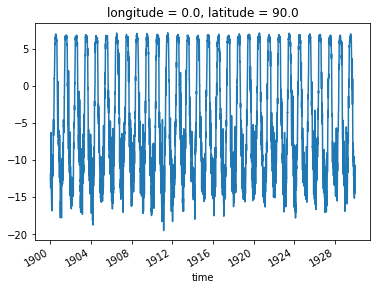

In [29]:
swbgt.rolling(time=14).mean().isel(time = np.arange(0,365*4*30)).plot()

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)

output_dtype = float
timestart = "1980-01-01"
timeend = "2010-12-31"
location = "europe_all"
# rolling_window = 4*365
timeslice = slice("2003-06-15", "2003-09-15")
load_dict = {
        't2m_path' : r"I:\Bachlor_thesis\Data\t2m_era20c_1900-2010.nc",
        'd2m_path' : r"I:\Bachlor_thesis\Data\td2m_era20c_1900-2010.nc",
        'time_slice' : slice(timestart, timeend),
        "latitude_slice" : slice(53.5, 51.5),
        "longitude_slice" : slice(12.5, 14.5),
        }

save_dict = {
        "savefolder" : r"C:\Users\Nils Niebaum\Documents\Uni\Bachlor_thesis\Prog\Data\\",
        "location" : location,
        "savename" : location + "_{}_{}.nc".format(timestart, timeend), # old: "savename" : r"swbgt" + "_{}_{}_{}.nc".format(location, timestart, timeend),
        "rechunked" : False,
        "quantiles" : False, #{"variables" : ["t2m"] , "quantiles" : np.array([0.98])} ,
        "deseason" : False, #{"variables" : ["t2m"] , "groupby" : "week"}, #"week",
        "detrend" : False, #{"variables" : ["t2m_deseason"]}, #False,
        "daily" : False #  please check this later !!! in the extern function
        }
plot_dict = {
        "doplot" : True,
        "levels" : np.arange(18, 35, 1),
        "savefolder" : r"C:\Users\Nils Niebaum\Documents\Uni\Bachlor_thesis\Prog\Plots\Cities\\"
        }


In [ ]:
data_1900= xr.open_dataset(r"C:\Users\Nils Niebaum\Documents\Uni\Bachlor_thesis\Prog\Data\europe_all_1900-01-01_1930-12-31.nc")
data_2010 = xr.open_dataset(r"C:\Users\Nils Niebaum\Documents\Uni\Bachlor_thesis\Prog\Data\europe_all_1980-01-01_2010-12-31.nc")
st = time.time()
data_1900_max = trends.calc_daily_max(data_1900, variable= "t2m")
print(time.time() - st)
st = time.time()
data_2010_max = trends.calc_daily_max(data_2010, variable= "t2m")
print(time.time() - st)

# data = sdd.save_calc_swbgt(save_dict= save_dict, load_dict = load_dict)
# print('loaded')
# st = time.time()
# data_max = trends.calc_daily_max(data, variable= "t2m")
# print(time.time() - st)

In [ ]:
max_dict = {
        "quantiles" : False, #{"variables" : ["t2m"] , "quantiles" : np.array([0.98])} ,
        "deseason" : False, #{"variables" : ["t2m"] , "groupby" : "dayofyear"},#, "rolling" : 14}, #"week",
        "detrend" : False, #{"variables" : ["t2m_deseason"]}, #False,
        "daily" : False #  please check this later !!! in the extern function
        }
try :
        data_max = data_max.drop_vars("t2m_deseason")
        data = data.drop_vars("t2m_deseason")
except : pass
sdd.add_missing_variables(data= data_1900_max, save_dict = max_dict, load_dict = load_dict)
sdd.add_missing_variables(data= data_2010_max, save_dict = max_dict, load_dict = load_dict)
# sdd.add_missing_variables(data= data, save_dict = max_dict, load_dict = load_dict)
data_1900_max.t2m.attrs["units"] = "degC"
# data.t2m_deseason.attrs["units"] = "degC"
data_2010_max.t2m.attrs["units"] = "degC"
# data_max.t2m_deseason.attrs["units"] = "degC"



In [ ]:
# NOTE: for the quantile mask, it has to be above the general 98th percentile!!

threshold = 26
duration = 3
quantile = 0.96

data_1900_max["t2m_mask_quantiles"] = data_1900_max["t2m"] >= data_1900["t2m"].quantile(quantile)
data_2010_max["t2m_mask_quantiles"] = data_2010_max["t2m"] >= data_2010["t2m"].quantile(quantile)

mask_lambda = lambda x : (x.t2m >= threshold) & x.t2m_mask_quantiles

st = time.time()
mask_1900 = hwi.calc_heatwave_index(mask_original= mask_lambda(data_1900_max), duration = duration)
print(time.time() -st)

st = time.time()
mask_2010 = hwi.calc_heatwave_index(mask_original= mask_lambda(data_2010_max), duration = duration)
print(time.time() -st)


In [ ]:

# plot city data
def plot_city_data_old(data = None, data_max = None,
        mask_res = None, city_name = "None", 
        timeslice= slice(timestart, timeend), groupby= "time.year" ):
        
    try: 
            data = data.mean("longitude").mean("latitude")
            data_max = data_max.mean("longitude").mean("latitude")
    except: 
            pass

    fig = plt.figure(figsize = (15,15))
    gs = gridspec.GridSpec(5, 2)

    # plot t2m 6h
    ax0 = fig.add_subplot(gs[0,:])
    data.t2m.sel(time = timeslice)\
            .plot(ax = ax0, color = "tab:blue", linewidth = "0.5",\
            label= "a) t2m - 6 hourly")
    # (data.t2m - data.t2m_deseason).sel(time = timeslice)\
    #         .plot(ax = ax0, color = "k", linewidth = "1",linestyle = ":",\
    #         label= "b) t2m - 6 hourly - seasonal mean")
    data.t2m.where(data.t2m >= data.t2m.quantile(quantile)).sel(time = timeslice)\
            .plot(ax = ax0, marker = 'x', color = "tab:orange",\
            label= "c) t2m - 6 hourly - 98th percentile")
    ax0.set_ylim([10,33])
    ax0.set_title("(I) 2m temperature (t2m) and its 98th percentile")


    # plot t2m daily max
    ax1 = fig.add_subplot(gs[1,:])
    data_max.t2m.sel(time = timeslice)\
            .plot(ax = ax1, color = "tab:blue", linewidth = "0.5",\
            label= "a) t2m - daily max")
    # (data_max.t2m -data_max.t2m_deseason).sel(time = timeslice)\
    #         .plot(ax = ax1, color = "k", linewidth = "1",linestyle = ":",\
    #         label= "b) t2m - daily max - seasonal mean")
    data_max.t2m.where(mask_res).sel(time = timeslice)\
            .plot(ax = ax1, marker = 'x', color = "tab:orange",\
            label= "c) t2m - daily max - dwd definition")
    ax1.set_ylim([10,33])
    ax1.set_title("(I) daily maximum 2m temperature (t2m)  in heatwaves")


    # DWD heat waves
    ax2 = fig.add_subplot(gs[3,:])
    data.t2m.sel(time = timeslice)\
            .plot(ax = ax2, color = "tab:blue", linewidth = "0.5",\
            label= "a) t2m - 6 hourly")
    data_max.t2m.sel(time = timeslice)\
            .plot(ax = ax2, color = "tab:purple", linewidth = "0.5",\
            label= "b t2m - daily max")
    data_max.t2m.where(mask_res).sel(time = timeslice)\
            .plot(ax = ax2, marker = 'x', color = "tab:red",\
            label= "c) t2m - daily max - mask_res") #.format(threshold))


    ax2.set_title("(II) 98th percentile of 2m temperature (t2m) and above ")
    ax2.set_ylim([10,33])
    ax2.set_ylabel("°C")



    # heatwave = xc.indices.heat_wave_index(data.t2m.where(data.t2m_mask_quantiles.isel(quantile= 0)), thresh= str(threshold) + " degC", window= 2, freq= "MS").sel(time = timeslice)
    # heatwave_max = xc.indices.heat_wave_index(data_max.t2m.where(data_max.t2m_mask_quantiles.isel(quantile= 0)), thresh= str(threshold) + " degC", window= 2, freq= "MS").sel(time = timeslice)

    # heatwave_max.plot(ax = ax[3], label = "xclim used daily max")
    # heatwave.plot(ax = ax[3],linestyle= ":", label = "xclim used 6 hourly")
    ax3 = fig.add_subplot(gs[2,:])
    
    y = mask_res.sel(time = timeslice).groupby(groupby).sum('time')

    if "year" in groupby:
        x = y.year
    elif "month" in groupby:
        x = y.month
    elif "week" in groupby:
        x = y.week
    else:
        x = y.time
    
    ax3.bar(x = x, height = y, label = "xclim used daily max", align = "center")
    # city(mask_org).sel(time = timeslice).groupby('time.month').sum('time').plot(ax = ax3,linestyle= ":", label = "xclim used 6 hourly")
    ax3.set_ylabel("heat wave days")

    # ax4 = fig.add_subplot(gs[4,:])
    # x = data_max.t2m.where(city(mask_res)) #.sel(time = timeslice)
    # y = data_max.swbgt.where(city(mask_res)) #.sel(time = timeslice)
    # c = data_max["time.month"].values
    # sct = ax4.scatter(x,y, c = c, cmap = "hsv")
    # ax4.set_xlabel("t2m in °C")
    # ax4.set_ylabel("sWBGT unitless")
    # plt.colorbar(sct)

    for axs in [ax0, ax1, ax3] :
            axs.grid()
            axs.legend()
            axs.get_shared_x_axes().join(axs, ax2)
            axs.set_xticklabels([])
            axs.set_xlabel("")
    ax2.grid()
    ax2.legend()
    # ax2.set_xticklabels([])
    # data_max.t2m.where(Paris(mask_org)).sel(time = timeslice).plot(ax = ax[3], marker = "+")
    # data_max.t2m.where(Paris(mask_res)).sel(time = timeslice).plot(ax = ax[3], marker = "x")

    # fig.savefig(plot_dict["savefolder"] + plot_dict["savename"]+ "hw_{}_{}_{}.png".format(city_name,timeslice.start, timeslice.stop))
    return fig

def plot_city_data(data = None, data_max = None,
        mask_res = None, city_name = "None", 
        timeslice= slice(timestart, timeend), groupby= "time.year",
        color_bar = "tomato" , color_scatter = "tomato" , color_hist = "tomato"):
        
    try: 
            data = data.mean("longitude").mean("latitude")
            data_max = data_max.mean("longitude").mean("latitude")
    except: 
            pass

    fig = plt.figure(figsize = (15,15))
    gs = gridspec.GridSpec(3, 2)

    fig.suptitle(city_name + ": " + timeslice.start + " - " + timeslice.stop + "\nheatwave similar to DWD definition \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature".format(duration, threshold, quantile*100),\
            fontsize= 15)
    # plot temperature
    ax1 = fig.add_subplot(gs[0,:])
    data.t2m.sel(time = timeslice)\
            .plot(ax = ax1, color = "k", linewidth = "0.3",linestyle = ":", alpha= 0.75,\
            label= "a) temperature - 6 hourly")
    data_max.t2m.sel(time = timeslice)\
            .plot(ax = ax1, color = "tab:blue", linewidth = "0.5",\
            label= "b) temperature - daily max")
    data_max.t2m.where(mask_res).sel(time = timeslice)\
            .plot(ax = ax1, marker = 'x', color = "tab:orange",\
            label= "c) heatwaves days")
    ax1.set_ylim([-5,35])
    ax1.set_title("")
    ax1.set_ylabel("temperature in °C")
    leg = ax1.legend(loc = "lower left")
    ax1.grid()

    # plot bar plot
    ax2 = fig.add_subplot(gs[1,:], sharex = ax1)
    y = mask_res.sel(time = timeslice).groupby(groupby).sum('time')

    if "year" in groupby:
        # x = y.year
        x = data_max.time[data_max.time.dt.is_year_start].sel(time = timeslice)
        w = (x[1]-x[0])/2
        ax2.bar(x = x + w , height = y, width = w, align = "center")
    elif "month" in groupby:
        x = data_max.time[data_max.time.dt.is_month_start].sel(time = timeslice)
        w = (x[1]-x[0])/2
        ax2.bar(x = x + w , height = y, width = w/2, align = "center")
    elif "week" in groupby:
        x = x.week
        w = (x[1]-x[0])/2
    else:
        x = y.time
    
    
    # city(mask_org).sel(time = timeslice).groupby('time.month').sum('time').plot(ax = ax3,linestyle= ":", label = "xclim used 6 hourly")
    ax2.set_ylabel("heat wave days per year")
    
    # ax2.legend()
    ax2.grid()
    # ax1.set_xticklabels([])

    ax3 = fig.add_subplot(gs[2:3,0])
    x = data_max.t2m.where(mask_res).sel(time = timeslice)
    y = data_max.swbgt.where(mask_res).sel(time = timeslice)
    c = data_max.d2m.where(mask_res).sel(time = timeslice)
    # c = data_max["time.month"].values
    sct = ax3.scatter(x,y)
    ax3.set_xlabel("temperature in °C")
    ax3.set_ylabel("sWBGT")
    ax3.set_xlim([24,38])
    ax3.set_ylim([18,30])
    ax3.grid()

    ax4 = fig.add_subplot(gs[2:3,1])
    bins = np.arange(19,28)
    ax4.hist(x = y, bins = bins ,density = True)
    ax4.set_xlabel("sWBGT")
    ax4.set_ylabel("density")
    ax4.set_ylim([0,0.35])
    ax4.grid()

    return fig


In [ ]:

timestart = "1980-01-01"
timeend = "2010-12-31"

plt.style.use('default')
timeslice = slice(timestart, timeend)
groupby = "time.year"

defintion = "MOD_{:.0f}day_{:.0f}thr_{:.0f}quant".format(duration,threshold,quantile*100)

# Paris
city_name = "Paris"
save_name = city_name + "_{}_{}_{}".format(timeslice.start[0:7], timeslice.stop[0:7], defintion)
city = lambda ds : ds.sel(method="nearest", latitude = 48.86, longitude = -2.35) 
fig = plot_city_data(data = city(data_2010), data_max = city(data_2010_max), mask_res = city(mask_2010), city_name = city_name, timeslice = timeslice, groupby = groupby)
fig.savefig(plot_dict["savefolder"] + save_name + '.png')
# fig.savefig(plot_dict["savefolder"] + save_name + '.svg')

# Berlin
city_name = "Berlin"
save_name = city_name + "_{}_{}_{}".format(timeslice.start[0:7], timeslice.stop[0:7], defintion)
city = lambda ds : ds.sel(method="nearest", latitude = 52.5, longitude = 13.4) 
fig = plot_city_data(data = city(data_2010), data_max = city(data_2010_max), mask_res = city(mask_2010), city_name = city_name, timeslice = timeslice, groupby = groupby)
fig.savefig(plot_dict["savefolder"] + save_name + '.png')
# fig.savefig(plot_dict["savefolder"] + save_name + '.svg')

# Moscow
city_name = "Moscow"
save_name = city_name + "_{}_{}_{}".format(timeslice.start[0:7], timeslice.stop[0:7], defintion)
city = lambda ds : ds.sel(method="nearest", latitude = 55.76, longitude = 37.62) 
fig = plot_city_data(data = city(data_2010), data_max = city(data_2010_max), mask_res = city(mask_2010), city_name = city_name, timeslice = timeslice, groupby = groupby)
fig.savefig(plot_dict["savefolder"] + save_name + '.png')
# fig.savefig(plot_dict["savefolder"] + save_name + '.svg')
